### Tema3 - Ejercicio

La base de datos Diabetes in Pima Indian Women, incluida en la librería MASS, contiene una muestra de 532 pacientes en edad adulta utilizada para realizar un estudio sobre la diabetes.

[Exportados los registros desde RStudio. Fichero pima.csv]


Bibliografía:

https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/

https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn



Importamos dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Cargamos el archivo entrada csv con pandas, indicando como separador la coma. Con head(5) vemos los 5 primeros registros.

In [3]:
pimadf = pd.read_csv(r"pima.csv",sep=',')
pimadf = pimadf.drop(pimadf.columns[[0]], axis=1)    # remove first column (it is just a file counter because of data being imported from R into csv)
pimadf = pimadf.rename(columns={"type": "diagnosis"})  # rename column name
pimadf.head(5)

,npreg,glu,bp,skin,bmi,ped,age,diagnosis
0,5,86,68,28,30.2,0.364,24,No
1,7,195,70,33,25.1,0.163,55,Yes
2,5,77,82,41,35.8,0.156,35,No
3,0,165,76,43,47.9,0.259,26,No
4,0,107,60,25,26.4,0.133,23,No


In [4]:
# Split the data into features (X) and target (y)
pimadf_target = pimadf['diagnosis']
pimadf_features = pimadf.drop('diagnosis', axis=1)


**Resumen estadístico**

El equivalente a la función summary de R en pandas es describe:

In [5]:
#Summary before normalization of features
pimadf_features.describe()

,npreg,glu,bp,skin,bmi,ped,age
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,32.890226,0.502966,31.614662
std,3.312036,30.999226,12.310253,10.523878,6.881109,0.344546,10.761584
min,0.000000,56.000000,24.000000,7.000000,18.200000,0.085000,21.000000
25%,1.000000,98.750000,64.000000,22.000000,27.875000,0.258750,23.000000
50%,2.000000,115.000000,72.000000,29.000000,32.800000,0.416000,28.000000
75%,5.000000,141.250000,80.000000,36.000000,36.900000,0.658500,38.000000
max,17.000000,199.000000,110.000000,99.000000,67.100000,2.420000,81.000000


In [6]:
#Summary of target variable
diagnosisTable = pimadf.groupby("diagnosis")
totals = diagnosisTable.size()
total = sum(totals)
print(totals)

diagnosis
No     355
Yes    177
dtype: int64


In [7]:
# Replace No,Yes by 0 and 1 so we can use jaccard index
pimadf_target.replace(['No', 'Yes'], [0,1], inplace=True)

# The same but in one line:
pimadf_target.value_counts()

diagnosis
0    355
1    177
Name: count, dtype: int64

### Normalizar el dataFrame con MinMaxScaler de scikit-learn:

In [8]:
scaler = MinMaxScaler()
pimadf_norm = pd.DataFrame(scaler.fit_transform(pimadf_features), columns=pimadf_features.columns)
#print(pimadf_norm)
pimadf_norm.head(5)

,npreg,glu,bp,skin,bmi,ped,age
0,0.294118,0.209790,0.511628,0.228261,0.245399,0.119486,0.050000
1,0.411765,0.972028,0.534884,0.282609,0.141104,0.033405,0.566667
2,0.294118,0.146853,0.674419,0.369565,0.359918,0.030407,0.233333
3,0.000000,0.762238,0.604651,0.391304,0.607362,0.074518,0.083333
4,0.000000,0.356643,0.418605,0.195652,0.167689,0.020557,0.033333


In [9]:
#Summary after normalization
pimadf_norm.describe()

,npreg,glu,bp,skin,bmi,ped,age
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.206877,0.454756,0.552391,0.241112,0.300414,0.179000,0.176911
std,0.194826,0.216778,0.143142,0.114390,0.140718,0.147557,0.179360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.298951,0.465116,0.163043,0.197853,0.074411,0.033333
50%,0.117647,0.412587,0.558140,0.239130,0.298569,0.141756,0.116667
75%,0.294118,0.596154,0.651163,0.315217,0.382413,0.245610,0.283333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Se comprueba que todos los valores están ahora entre 0 y 1.

### Crear conjuntos de datos para entrenamiento y para test

Crear los conjuntos de entrenamiento y de test/evaluación:

In [10]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(pimadf_norm, pimadf_target, test_size=0.3)

In [11]:
print(f"Shape of x_train: {x_train.shape} - shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape} - shape of y_test: {y_test.shape}")
#In R, we had 373 rows to train, and 159 to test

Shape of x_train: (372, 7) - shape of x_test: (160, 7)
Shape of y_train: (372,) - shape of y_test: (160,)


Llamar a la función KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [13]:
predictions_knn = knn.predict(x_test)

In [14]:
knn_accuracy = accuracy_score(y_test, predictions_knn)
knn_precision = precision_score(y_test, predictions_knn, pos_label=1)
knn_recall = recall_score(y_test, predictions_knn, pos_label=1)
knn_jac = jaccard_score(y_test,predictions_knn)
knn_f1 = f1_score(y_test,predictions_knn)


Report = {"Metrics":["Accuracy","Precision","Recal","Jaccard score","F1 score"],"Result": [knn_accuracy,knn_precision,knn_recall,knn_jac,knn_f1]}
pd.DataFrame(Report)

,Metrics,Result
0,Accuracy,0.762500
1,Precision,0.764706
2,Recal,0.464286
3,Jaccard score,0.406250
4,F1 score,0.577778


### Cross table/Confusion matrix:


In [15]:
conf_matrix = confusion_matrix(y_test, predictions_knn, labels=[0,1])
conf_matrix

array([[96,  8],
       [30, 26]])

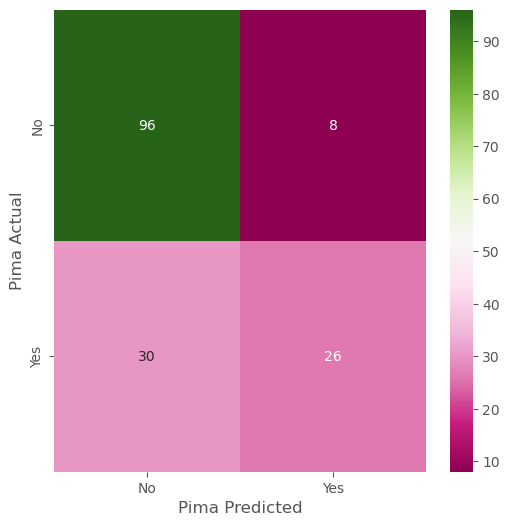

In [16]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='PiYG', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Pima Predicted', fontsize=12)
plt.ylabel('Pima Actual', fontsize=12)
plt.show()

Análisis de la tabla:

- El algoritmo ha predicho 90 resultados negativos de manera correcta. 
- Pero en cambio ha devuelto 26 resultados como negativos, cuando en realidad son positivos (falsos negativos).
Esto puede tener consecuencias bastante importantes, porque los pacientes pueden pensar que no tienen un problema (diabetes en este caso), y retrasar el tratamiento.
- El algoritmo también ha devuelto bastantes falsos positivos: ha devuelto 14 como casos de diabetes que en realidad no lo son.
- Sí ha devuelto 30 positivos de manera correcta.